In [1]:
!pip install razdel
!pip install pymorphy2
!pip install pyLDAvis
!pip install langdetect
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import re
from collections import Counter

import razdel
import nltk
nltk.download('stopwords')
import pymorphy2
import gensim
import numpy as np
plt.style.use('ggplot')
import plotly
from tqdm import tqdm_notebook
from sklearn.manifold import TSNE

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.gensim

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 8.2MB 6.9MB/s 
     |████████████████████████████████| 1.6MB 4.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=7ac90ce3eb12798c8a43e472db9916bda9c572021ceb129008f3e47e2d6acccc
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
     |████████████████████████████████| 983kB 4.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=31c9886e155508c0aeb4255c2e86da830a0becdc3717b57766969325073fb5c3
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/data7/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data7/test.csv')

In [ ]:
#train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

## Посмотрим на длины предложений

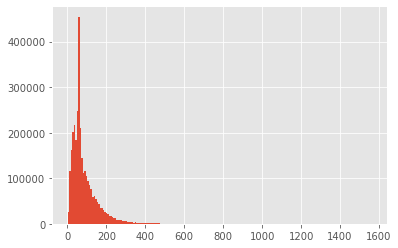

In [ ]:
train_df.sentence.str.len().hist(bins=200);

## Есть явные выбросы

In [ ]:
train_df.sentence.str.len().value_counts()

56      123392
60      122226
63       96774
49       75005
66       70564
         ...  
867          1
866          1
857          1
854          1
1564         1
Name: sentence, Length: 923, dtype: int64

## Теперь посмотрим на популярные предложения

In [4]:
def tokenize(text):
    return text.lower()

In [5]:
docs = [tokenize(text) for text in train_df.sentence.values]

In [ ]:
gg = Counter()
for doc in docs:
    gg[doc] += 1
gg.most_common(20)

[('що це тому ми чи дуже які щоб дякую якщо було вона від мене ось', 75000),
 ('гэта што калі мы не яны як але ён каб дзякуй больш пра на вы', 50000),
 ('бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы', 50000),
 ('що це ми не як на вони та але ви до про він оплески коли', 50000),
 ('это что мы не как на вы они но из то он так для аплодисменты', 50000),
 ('the and of it that you to apos we this is in they so are', 50000),
 ('笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧', 25000),
 ('笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說', 25000),
 ('( aplausos )', 1299),
 ('( applaus )', 1078),
 ('( applause )', 835),
 ('( تصفيق )', 643),
 ('( 박수 )', 631),
 ('( applaudissements )', 627),
 ('( аплодисменты )', 621),
 ('( applausi )', 580),
 ('( aplauze )', 552),
 ('( מחיאות כפיים )', 551),
 ('( potlesk )', 530),
 ('（ 拍手 ）', 508)]

## Выбросим всё лишнее

In [6]:
def to_lower(text):
    return text.str.lower()

In [7]:
not_len = [56, 60, 63, 49, 66, 40]
not_str = ['що це ми не як на вони та але ви до про він оплески коли', 
           'the and of it that you to apos we this is in they so are',
          'гэта што калі мы не яны як але ён каб дзякуй больш пра на вы',
          'бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы',
          'що це тому ми чи дуже які щоб дякую якщо було вона від мене ось',
          'это что мы не как на вы они но из то он так для аплодисменты',
          '笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧',
          '笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說']
train_df = train_df.loc[~train_df.sentence.str.len().isin(not_len)].apply(to_lower)
train_df = train_df.loc[~train_df.sentence.isin(not_str)].apply(to_lower)

## Выделим символы, которые есть во всех языках

In [9]:
train_df['k'] = ' '
train_df['gg'] = train_df[['language', 'k', 'sentence']].sum(axis = 1)

In [10]:
ff = {}
for i in tqdm_notebook(train_df['gg']):
    for j in range(2, len(i)):
        if i[0:2] in ff:
            ff[i[0:2]].add(i[j]) 
        else:
            ff[i[0:2]] = set()
            ff[i[0:2]].add(i[j])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [11]:
Spisok = ff['fr'].copy()

In [12]:
for i in ff.items():
    #print(type(i[1]))
    Spisok.intersection_update(i[1])


In [ ]:
Spisok

## Word2vec

In [13]:
TOKEN_PATTERN_ru = "[а-яё]+"
TOKEN_PATTERN_en = "[a-z]+"
corpus = train_df.sentence.values

In [15]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [19]:
lemmatizer = pymorphy2.MorphAnalyzer()
stopword_set = set(nltk.corpus.stopwords.words('russian'))
stopword_set = stopword_set.union({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.6/dist-

In [20]:
def prepare_sentence_dataset(documents):
    tokenized_sentences = []
    for document in tqdm_notebook(documents):
        for sentence in razdel.sentenize(document):
            lemmatized_tokens = [lemmatize(token) for token in re.findall(TOKEN_PATTERN_ru, sentence.text.lower())]
            tokenized_sentences.append(
                [token for token in lemmatized_tokens if token not in stopword_set]
            )
    return tokenized_sentences

sentence_dataset = prepare_sentence_dataset(corpus)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [21]:
word2vec = gensim.models.Word2Vec(
    size=100, sg=0, window=5, min_count=5, negative=20
)

In [22]:
word2vec.build_vocab(sentence_dataset)

In [23]:
word2vec.train(sentence_dataset, total_examples=word2vec.corpus_count, epochs=30)

(78199873, 88447710)

In [24]:
index2word = np.array(word2vec.wv.index2word)

In [25]:
embeddings = word2vec.wv.vectors

In [26]:
ids = np.random.randint(low=0, high=index2word.size, size=2000)

In [28]:
embeddings_reduced = TSNE(random_state=42, n_components=2).fit_transform(embeddings[ids])

In [29]:
def plot_tsne_embeddings(embeddings, annotations):

    trace = plotly.graph_objs.Scattergl(
        x = embeddings[:, 0],
        y = embeddings[:, 1],
        name = 'Embedding',
        mode = 'markers',

        marker = dict(
            colorscale='Viridis',
            size = 6,
            line = dict(width = 0.5),
            opacity=0.75
        ),
        text=annotations
    )

    layout = dict(
        title = "Word2Vec 2D TSNE Embeddings",
        yaxis = dict(zeroline = False),
        xaxis = dict(zeroline = False),
        hovermode = 'closest',
        width=800,
        height=800
    )

    return plotly.graph_objs.Figure(data=[trace], layout=layout)

In [30]:
plot_tsne_embeddings(embeddings_reduced, index2word[ids])

## Выделим коллокации для двух языков

In [ ]:
def tokenize_ru(text):
    return re.findall(TOKEN_PATTERN_ru, text.lower())

def tokenize_en(text):
    return re.findall(TOKEN_PATTERN_en, text.lower())

docs_en = [tokenize_en(text) for text in corpus]
docs_ru = [tokenize_ru(text) for text in corpus]

In [ ]:
stopword_set_ru = set(nltk.corpus.stopwords.words('russian'))
stopword_set_ru = stopword_set_ru.union({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})
stopword_set_en = set(nltk.corpus.stopwords.words('english'))
lemmatizer_cache = {}
lemmatizer = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [ ]:
lemmatized_docs_ru = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs_ru)]
cleared_docs_ru = [[token for token in text if token not in stopword_set_ru] for text in tqdm_notebook(lemmatized_docs_ru)]

In [ ]:
lemmatized_docs_en = [[token for token in text] for text in tqdm_notebook(docs_en)]
cleared_docs_en = [[token for token in text if token not in stopword_set_en] for text in tqdm_notebook(lemmatized_docs_en)]

In [ ]:
cooccurence_ru = Counter()

for doc in cleared_docs_ru:
    for i in range(len(doc) - 1):
        cooccurence_ru[(doc[i], doc[i + 1])] += 1

In [ ]:
cooccurence_ru.most_common(30)

In [ ]:
cooccurence_en = Counter()

for doc in cleared_docs_en:
    for i in range(len(doc) - 1):
        cooccurence_en[(doc[i], doc[i + 1])] += 1

In [ ]:
cooccurence_en.most_common(30)

## Сonfusion matrix

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
x = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [35]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer(
             min_df=3, max_df=0.78, token_pattern=r"[^-\s\d.,;!]+"
                    )
    ),
    ('model', SGDClassifier(random_state=42, loss='log', class_weight='balanced')),
])

In [36]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.78,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='[^-\\s\\d.,;!]+',
                                 tokenizer=None, vocabular...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                               loss='log', max_iter=1

In [39]:
predictions = pipe.predict(x_test)

In [40]:
confusion_matrix(y_test, predictions)

array([[24142,     0,     0, ...,    14,     0,     0],
       [    0,   578,     0, ...,     0,     1,     0],
       [    0,     0,   544, ...,     3,     0,     0],
       ...,
       [    0,     0,     0, ...,   102,   191,    47],
       [    0,     0,     0, ...,  1844, 15254,  1544],
       [    0,     2,     0, ...,  2261, 10168,  4691]])